# Modelling Exploration Notebook V1

This Notebook compares different forecast models provided by GluonTS. <br />
Experiments are run using Python 3.9 and PyTorch 1.13. <br />
Compared were:

- DeepAR (Salinas et al. 2020): [torch impl](https://github.com/awslabs/gluonts/blob/dev/src/gluonts/torch/model/deepar/estimator.py)
- DeepState (Rangapuram et al. 2018): [mx impl](https://github.com/awslabs/gluonts/blob/dev/src/gluonts/mx/model/deepstate/_estimator.py)
- MQ-CNN (Wen et al. 2017): [mx impl](https://github.com/awslabs/gluonts/blob/dev/src/gluonts/mx/model/seq2seq/_mq_dnn_estimator.py)


In [1]:
# Imports experiment script
from src.forecast_experiment import run_experiment
from src.forecast_util import plot_forecast

# Import packages
from datetime import timedelta
import json
import pickle

## Experiment Overview


### Define Configuration Store


In [2]:
from sqlalchemy import create_engine, Column, Integer, Float, String, PickleType, select
from sqlalchemy.orm import declarative_base
from sqlalchemy.orm import sessionmaker

In [3]:
Base = declarative_base()


class Forecast_Experiment(Base):
    __tablename__ = "forecast_experiment"
    id = Column("id", Integer, primary_key=True)
    model = Column("model name", String(20))
    version = Column("version", Integer)
    data_config = Column("data_config", PickleType)
    model_config = Column("model_config", PickleType)
    MASE = Column("MASE", Float)
    MAPE = Column("MAPE", Float)
    RMSE = Column("RMSE", Float)
    wQL_10 = Column("wQL_10", Float)
    wQL_50 = Column("wQL_50", Float)
    wQL_90 = Column("wQL_90", Float)
    avg_wQL = Column("avg_wQL", Float)

In [4]:
engine = create_engine("sqlite:///./config/forecast_config_v2.db")

Base.metadata.create_all(bind=engine)
Session = sessionmaker(bind=engine)
session = Session()

### Explore Experiments


The model name follows this naming convention: {framework}\_{model_name}. <br />

- The framework specifies the Machine Learning Framework used to implement the model (mxnet, torch, tensorflow)
- The model_name specifies the Algorithm used (e.g. DeepAR).

The version field is used to track the stage of experiments as defined below. This means general progression of modelling insights as well as updated data sources.

- version 1: first exploration
  - "../data_engineering/financial_ts/indices.csv",
  - "../data_engineering/financial_ts/ww_gdp.csv",
  - "../data_engineering/timeseries_data/ts_dgelt_events.csv"
- version 2: specific exploration
  - "../data_engineering/financial_ts/indices.csv",
  - "../data_engineering/financial_ts/ww_gdp.csv",
  - "../data_engineering/timeseries_data/ts_gdelt_5k_per_year_data.csv"


In [5]:
# Query experiment Table and print results:
q1 = select(Forecast_Experiment).order_by(Forecast_Experiment.avg_wQL)
q1_result = session.execute(q1)

for s in q1_result.scalars():
    print(
        f"""{s.model}: {s.version} 
        - model_config: {str(s.model_config)[1:-1].replace("'","")}:
        - MAPE: {s.MAPE},
        - avg_wQL: {s.avg_wQL},
        """
    )

torch_deepar: 2 
        - model_config: epochs: 50, prediction_length: 52, num_layers: 3, hidden_size: 20, context_length: 100, lr: 0.001, weight_decay: 1e-15:
        - MAPE: 0.04146326392940672,
        - avg_wQL: 0.027844774271000128,
        
torch_deepar_8year_v6_without_gdelt: 2 
        - model_config: epochs: 100, prediction_length: 52, num_layers: 3, hidden_size: 20, context_length: 200, lr: 0.001, weight_decay: 1e-15:
        - MAPE: 0.04183947846963372,
        - avg_wQL: 0.02852174773958928,
        
torch_deepar: 1 
        - model_config: epochs: 1000, prediction_length: 20, num_layers: 8, hidden_size: 64, context_length: 56, lr: 0.001, weight_decay: 1e-08:
        - MAPE: 0.04679007808624215,
        - avg_wQL: 0.03054266891615841,
        
torch_deepar: 2 
        - model_config: epochs: 400, prediction_length: 56, num_layers: 2, hidden_size: 30, context_length: 200, lr: 0.001, weight_decay: 1e-08:
        - MAPE: 0.055167913723884784,
        - avg_wQL: 0.032864262677

### Migrate Experiments


The Experiments from the modelling_experimentation_v1 notebook are stored in two different tables. <br>
They are exported to a json file with the following code to read the file and store previous experiments in the new database with dynamic config attributes.


In [6]:
# Open JSON file with experiment data
# with open("data_v2.json") as json_file:
#     data = json.load(json_file)

In [7]:
# for e in data:
#     experiment_config = Forecast_Experiment(
#         model=e["name"],
#         version=1,
#         data_config={
#             "target": e["target"],
#             "past_rts_col": e["past_rts_col"],
#             "windows": 1,
#         },
#         model_config={
#             "epochs": e["epochs"],
#             "prediction_length": e["prediction_length"],
#             "num_layers": e["num_layers"],
#             "hidden_size": e["hidden_size"],
#             # 'context_length':e['context_length'],
#             "lr": e["lr"],
#             "weight_decay": e["weight_decay"],
#         },
#         MASE=e["MASE"],
#         MAPE=e["MAPE"],
#         RMSE=e["RMSE"],
#         wQL_10=e["wQL_10"],
#         wQL_50=e["wQL_50"],
#         wQL_90=e["wQL_90"],
#         avg_wQL=e["avg_wQL"],
#     )
#     session.add(experiment_config)
#     session.commit()

## DeepAR ([torch](https://github.com/awslabs/gluonts/blob/dev/src/gluonts/torch/model/deepar/estimator.py))


DeepAR is a methodology for producing accurate probabilistic forecasts, based on training an autoregressive recurrent neural network model on a large number of related time series.


In [8]:
from gluonts.torch import DeepAREstimator

In [9]:
# Data specs
input_paths = [
    "../data_engineering/financial_ts/indices.csv",
    "../data_engineering/financial_ts/ww_gdp.csv",
    "../data_engineering/timeseries_data/ts_gdelt_5k_per_year_data.csv",
]

target_col = "ts_S&P"  # switch to ts_S&P
with open("./config/past_rts_cols_v2.json", "r") as fp:
    past_rts_col = json.load(fp)["version_2"]
windows = 8

# Estimator specs
version = 2
prediction_length = 52
max_epochs = 100
num_layers = 3
hidden_size = 20
context_length = 200
weight_decay = 1e-15
lr = 0.001
offset = -(prediction_length * windows)

# Trainer specs
accelerator = "cpu"
devices = "auto"

In [10]:
# Define estimator
deepar_estimator = DeepAREstimator(
    prediction_length=prediction_length,
    num_layers=num_layers,
    hidden_size=hidden_size,
    weight_decay=weight_decay,
    context_length=context_length,
    lr=lr,
    freq="W",
    trainer_kwargs={
        "max_epochs": max_epochs,
        "accelerator": accelerator,
        "devices": devices,
    },
)

In [11]:
# Start Experiment
forecasts, tss, agg_metrics = run_experiment(
    input_paths=input_paths,
    target_col=target_col,
    prediction_length=prediction_length,
    windows=windows,
    offset=offset,
    past_rts_col=past_rts_col,
    estimator=deepar_estimator,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(

  | Name  | Type        | Params | In sizes | Out sizes   
-----------

Training: 0it [00:00, ?it/s]

Epoch 0, global step 50: 'train_loss' reached 5.72828 (best 5.72828), saving model to '/Users/adavidho/Documents/University/DHBW/Semester 4/Data Exploration/Project/project_submission_haiperformer/modelling/lightning_logs/version_6/checkpoints/epoch=0-step=50.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=1` reached.
Running evaluation: 1it [00:00,  6.89it/s]


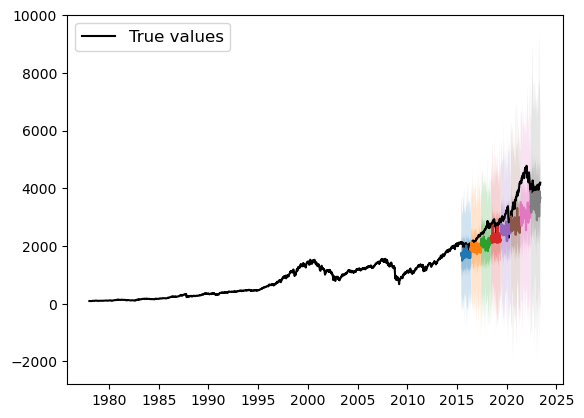

In [12]:
# Plot forecast
plot_forecast(
    tss=tss,
    forecasts=forecasts,
    path="./8year_test.svg",
)

In [13]:
with open("8year_test_tss.pkl", "wb") as outp:
    pickle.dump(tss, outp, pickle.HIGHEST_PROTOCOL)

with open("8year_test_forecasts.pkl", "wb") as outp:
    pickle.dump(forecasts, outp, pickle.HIGHEST_PROTOCOL)

In [14]:
# Add experiment to database store
experiment_config = Forecast_Experiment(
    model="torch_deepar_8year_v6",
    version=version,
    data_config={
        "target": target_col,
        "past_rts_col": past_rts_col,
        "windows": windows,
    },
    model_config={
        "epochs": max_epochs,
        "prediction_length": prediction_length,
        "num_layers": num_layers,
        "hidden_size": hidden_size,
        "context_length": context_length,
        "lr": lr,
        "weight_decay": weight_decay,
    },
    MASE=agg_metrics["MASE"],
    MAPE=agg_metrics["MAPE"],
    RMSE=agg_metrics["RMSE"],
    wQL_10=agg_metrics["wQuantileLoss[0.1]"],
    wQL_50=agg_metrics["wQuantileLoss[0.5]"],
    wQL_90=agg_metrics["wQuantileLoss[0.9]"],
    avg_wQL=agg_metrics["mean_wQuantileLoss"],
)
session.add(experiment_config)
session.commit()

## DeepState ([mx](https://github.com/awslabs/gluonts/blob/dev/src/gluonts/mx/model/deepstate/_estimator.py))


DeepState is a novel approach to probabilistic time series forecasting that combines state space models with deep learning. By parametrizing a per-time-series linear state space model with a jointly-learned recurrent neural network, our method retains desired properties of state space models such as data efficiency and interpretability, while making use of the ability to learn complex patterns from raw data offered by deep learning approaches.


In [15]:
from gluonts.mx import DeepStateEstimator
from gluonts.mx import Trainer

In [16]:
# Data specs
input_paths = [
    "../data_engineering/financial_ts/indices.csv",
    "../data_engineering/financial_ts/ww_gdp.csv",
    "../data_engineering/timeseries_data/ts_gdelt_5k_per_year_data.csv",
]

target_col = "ts_S&P"
with open("./config/past_rts_cols_v2.json", "r") as fp:
    past_rts_col = json.load(fp)["version_2"]
windows = 1

# Estimator specs
version = 1
prediction_length = 56
num_layers = 2
hidden_size = 20
offset = -(prediction_length * windows)

# Trainer specs
max_epochs = 100
lr = 1e-1
weight_decay = 1e-4

In [17]:
# Define estimator
deepstate_estimator = DeepStateEstimator(
    prediction_length=prediction_length,
    num_layers=num_layers,
    num_cells=hidden_size,
    use_feat_static_cat=False,
    cardinality=[],
    trainer=Trainer(
        epochs=max_epochs,
        learning_rate=lr,
        weight_decay=weight_decay,
    ),
    freq="W",
)

In [18]:
# Start Experiment
forecasts, tss, agg_metrics = run_experiment(
    input_paths=input_paths,
    target_col=target_col,
    prediction_length=prediction_length,
    windows=windows,
    offset=offset,
    past_rts_col=past_rts_col,
    estimator=deepstate_estimator,
)

100%|██████████| 50/50 [01:25<00:00,  1.72s/it, epoch=1/1, avg_epoch_loss=6.85]
Running evaluation: 1it [00:00,  5.66it/s]


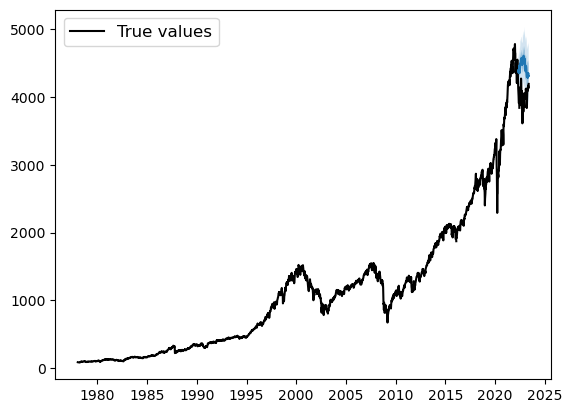

In [19]:
# Plot forecast
plot_forecast(
    tss=tss,
    forecasts=forecasts,
    # path="./plot.svg",
)

In [20]:
# Add experiment to database store
experiment_config = Forecast_Experiment(
    model="mx_deepstate",
    version=version,
    data_config={
        "target": target_col,
        "past_rts_col": past_rts_col,
        "windows": windows,
    },
    model_config={
        "epochs": max_epochs,
        "prediction_length": prediction_length,
        "num_layers": num_layers,
        "hidden_size": hidden_size,
        "lr": lr,
        "weight_decay": weight_decay,
    },
    MASE=agg_metrics["MASE"],
    MAPE=agg_metrics["MAPE"],
    RMSE=agg_metrics["RMSE"],
    wQL_10=agg_metrics["wQuantileLoss[0.1]"],
    wQL_50=agg_metrics["wQuantileLoss[0.5]"],
    wQL_90=agg_metrics["wQuantileLoss[0.9]"],
    avg_wQL=agg_metrics["mean_wQuantileLoss"],
)
session.add(experiment_config)
session.commit()

## MQ-CNN ([mx](https://github.com/awslabs/gluonts/blob/dev/src/gluonts/mx/model/seq2seq/_mq_dnn_estimator.py))


MQ-CNN is a general probabilistic multi-step time series regression model. It exploits the expressiveness and temporal nature of Sequence-to-Sequence Neural Networks (e.g. recurrent and convolutional structures), the nonparametric nature of Quantile Regression and the efficiency of Direct Multi-Horizon Forecasting.


In [21]:
from gluonts.mx import MQCNNEstimator
from gluonts.mx import Trainer

In [22]:
# Data specs
input_paths = [
    "../data_engineering/financial_ts/indices.csv",
    "../data_engineering/financial_ts/ww_gdp.csv",
    "../data_engineering/timeseries_data/ts_gdelt_5k_per_year_data.csv",
]

target_col = "ts_S&P"
with open("./config/past_rts_cols_v2.json", "r") as fp:
    past_rts_col = json.load(fp)["version_2"]
windows = 1

# Estimator specs
version = 1
prediction_length = 56
decoder_mlp_dim_seq = [30]
channels_seq = [30, 30, 30]
use_past_feat_dynamic_real = True
context_length = 50
offset = -(prediction_length * windows)

# Trainer specs
max_epochs = 100
lr = 1e-1
weight_decay = 1e-4

In [23]:
mqcnn_estimator = MQCNNEstimator(
    prediction_length=prediction_length,
    channels_seq=channels_seq,
    use_past_feat_dynamic_real=use_past_feat_dynamic_real,
    decoder_mlp_dim_seq=decoder_mlp_dim_seq,
    context_length=context_length,
    freq="W",
    trainer=Trainer(
        epochs=max_epochs,
        learning_rate=lr,
        weight_decay=weight_decay,
    ),
)

In [24]:
# Start Experiment
forecasts, tss, agg_metrics = run_experiment(
    input_paths=input_paths,
    target_col=target_col,
    prediction_length=prediction_length,
    windows=windows,
    offset=offset,
    past_rts_col=past_rts_col,
    estimator=mqcnn_estimator,
)

100%|██████████| 50/50 [00:13<00:00,  3.79it/s, epoch=1/1, avg_epoch_loss=38.9]
Running evaluation: 1it [00:00,  5.56it/s]


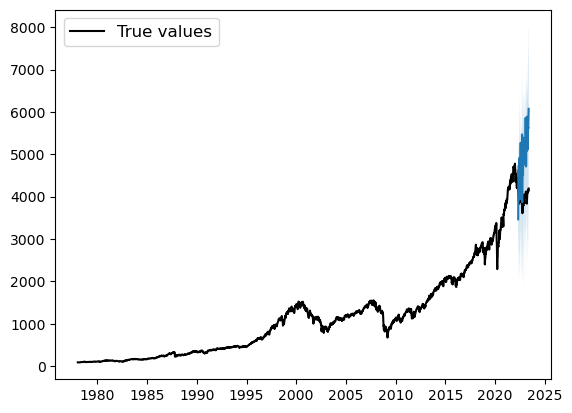

In [25]:
# Plot forecast
plot_forecast(
    tss=tss,
    forecasts=forecasts,
    # path="./plot.svg",
)

In [26]:
# Add experiment to database store
experiment_config = Forecast_Experiment(
    model="mx_cnnqr",
    version=version,
    data_config={
        "target": target_col,
        "past_rts_col": past_rts_col,
        "windows": windows,
    },
    model_config={
        "epochs": max_epochs,
        "prediction_length": prediction_length,
        "channels_seq": channels_seq,
        "decoder_mlp_dim_seq": decoder_mlp_dim_seq,
        "use_past_feat_dynamic_real": use_past_feat_dynamic_real,
        "context_length": context_length,
        "lr": lr,
        "weight_decay": weight_decay,
    },
    MASE=agg_metrics["MASE"],
    MAPE=agg_metrics["MAPE"],
    RMSE=agg_metrics["RMSE"],
    wQL_10=agg_metrics["wQuantileLoss[0.1]"],
    wQL_50=agg_metrics["wQuantileLoss[0.5]"],
    wQL_90=agg_metrics["wQuantileLoss[0.9]"],
    avg_wQL=agg_metrics["mean_wQuantileLoss"],
)
session.add(experiment_config)
session.commit()
print("done")

done
